In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['text.usetex'] = True
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split


In [2]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def get_batch(x, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return batch_x

In [103]:
# cols=['a', 'b', 'chi2_shuffled', 'chi2_observed','Z_shuffled_observed']
df = pd.read_csv('a_b_chi2observed_chi2shuffled_Z_shuffled_observed_Z_shuffled_point0_1000.csv')#[cols]
df.head()

,Unnamed: 0,a,b,chi2_shuffled,chi2_observed,chi2_point_0,Z_shuffled_observed,Z_shuffled_point0
0,0,0.890731,1.773921,44.148846,44.243912,0.000000,1.0,0.0
1,1,1.306220,1.490305,452.662911,169.498032,383.014353,0.0,0.0
2,2,1.653587,0.538929,42.495750,543.161327,795.553892,1.0,1.0
3,3,0.666805,1.375998,169.677849,236.745043,342.754111,1.0,1.0
4,4,1.105232,1.243956,93.226767,165.107046,411.137948,1.0,1.0


In [104]:
df.describe()

,Unnamed: 0,a,b,chi2_shuffled,chi2_observed,chi2_point_0,Z_shuffled_observed,Z_shuffled_point0
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,0.990061,1.093910,338.928240,311.278475,490.972263,0.497000,0.769000
std,288.819436,0.572408,0.513808,245.832804,160.524892,184.109089,0.500241,0.421683
min,0.000000,0.001196,0.200896,0.000000,44.243912,0.000000,0.000000,0.000000
25%,249.750000,0.511282,0.654855,142.222506,189.455125,361.471970,0.000000,1.000000
50%,499.500000,0.984827,1.089722,276.303389,250.785557,419.249029,0.000000,1.000000
75%,749.250000,1.500206,1.521528,482.607825,384.414735,547.076538,1.000000,1.000000
max,999.000000,1.999527,1.997974,1317.213927,1001.988784,1236.350505,1.000000,1.000000


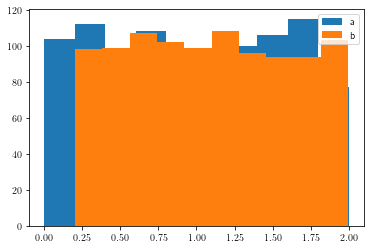

In [105]:
plt.hist(df['a'], label='a')
plt.hist(df['b'], label='b')
plt.legend()

In [116]:
def p_val_hist_ab(df, nbins_a, nbins_b):
    a = df['a']
    b = df['b']
    Z = df['Z_shuffled_observed']
    a_range=(a.min(), a.max())
    b_range=(b.min(), b.max())
    
    y_a_b_w, a_edges, b_edges = np.histogram2d(a, b, bins=(nbins_a, nbins_b), range=(a_range, b_range), weights= Z)
    y_a_b_uw, a_edges, b_edges = np.histogram2d(a, b, bins=(nbins_a, nbins_b), range=(a_range, b_range))
    eps=1e-15
    P_a_b = y_a_b_w/(y_a_b_uw + eps)
    
    return P_a_b, a_edges, b_edges

In [140]:
def make_binned_X(X_min, X_max, Nbins):
    X_step = (X_max-X_min) / Nbins
    bins = np.arange(X_min, X_max+X_step, X_step)
    bin_centers = (bins[1:] + bins[:-1])/2
    return np.array(bin_centers)

def bin_centers(edges):
    return (edges[1:] + edges[:-1])/2

def plot_p_val_hist_ab(df, ax, fig, nbins_a, nbins_b, save_plot=False):
    a = df['a']
    b = df['b']
    
    Z = df['Z_shuffled_point0']
    
    amin, amax = a.min(), a.max()
    bmin, bmax = b.min(), b.max()
    a_range=(amin, amax)
    b_range=(bmin, bmax)
    
    y_a_b_w, a_edges, b_edges = np.histogram2d(a, b, bins=(nbins_a, nbins_b), range=(a_range, b_range), weights= Z)
    y_a_b_uw, a_edges, b_edges = np.histogram2d(a, b, bins=(nbins_a, nbins_b), range=(a_range, b_range))
    eps=1e-15
    P_a_b = y_a_b_w/(y_a_b_uw + eps)
    
    print('ratio', P_a_b)
    
    # ax.hist2d(a, b, bins=(5,5), range= (a_range, b_range), weights = P_a_b, cmap='rainbow')
    
    # P_a_b, a_edges, b_edges =p_val_hist_ab(df)
    bin_centers_a = bin_centers(a_edges)
    bin_centers_b = bin_centers(b_edges)
    
    A, B = np.meshgrid(bin_centers_a, bin_centers_b)
    a_flat, b_flat = A.flatten(), B.flatten()
    
    print('shape of a_flat', a_flat.shape)
    print('shape of b_flat', b_flat.shape)
    P_a_b = P_a_b.T
    P_a_b = P_a_b.flatten()
    # _, _, _, colorbar = ax.hist2d(a_flat, b_flat, bins=(nbins_a,nbins_b), range= (a_range, b_range), cmap='rainbow', weights = P_a_b)
    # fig.colorbar(colorbar)
    ax.scatter(0.8907313813100579,1.7739212819523444, marker='X', color='black', s=54)
    ax.text(1,1.77, r'$\theta_0$', fontsize=25)
    P_a_b= P_a_b.reshape(A.shape)
    
    CLs=np.array([
                    # 0.683,
                  # 0.80, 
                  0.90,
                  # 0.95
                 ]
                )
    
    
    ax.contour(A, B, P_a_b, extent= (amin, amax, bmin, bmax), levels = CLs, linewidths = 2, 
                                       cmap='rainbow', 
                                        label='histogram approx',
                                         linestyles='dashed'
              )
    # fig.colorbar(colorbar)
    ax.grid()
    ax.set_xlabel(r'$a$',fontsize=20); ax.set_ylabel(r'$b$',fontsize=20)
    ax.set_xlim(amin, amax)
    ax.set_ylim(bmin, bmax)
    return P_a_b, xedges, yedges

ratio [[0.73333333 0.82692308 0.38095238 0.525      0.51923077]
 [0.84615385 0.77272727 0.85714286 0.82222222 0.51515152]
 [0.79411765 0.84848485 0.86363636 0.68421053 0.73170732]
 [0.95744681 0.9047619  0.83333333 0.85714286 0.76470588]
 [0.82978723 0.84210526 0.92105263 0.75       0.83783784]]
shape of a_flat (25,)
shape of b_flat (25,)


/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: The following kwargs were not used by contour: 'label'


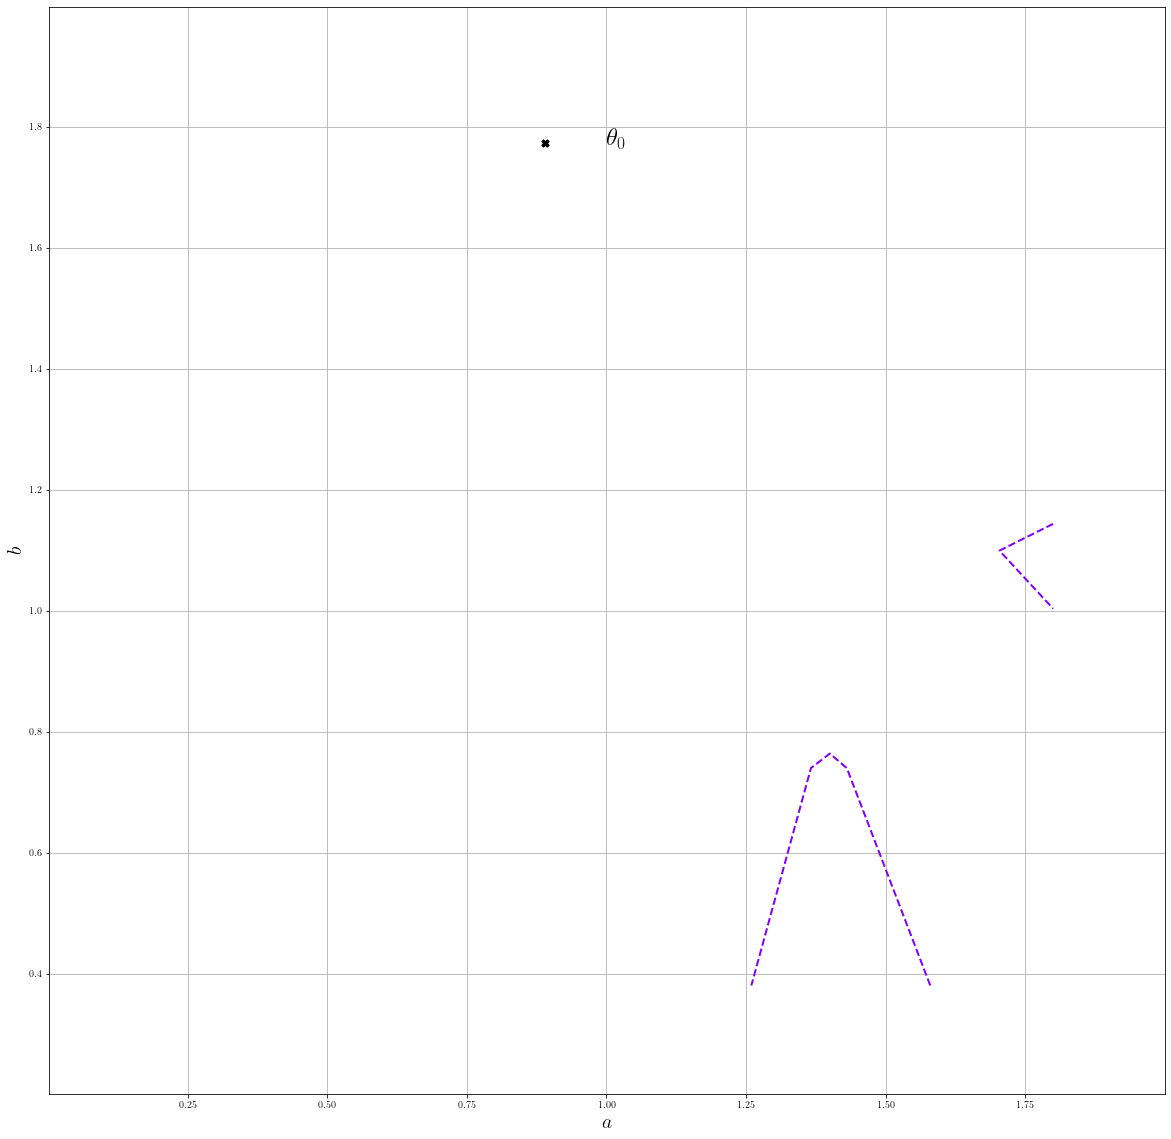

In [141]:
figwidth_by_height_ratio=1.33
height=20
width=figwidth_by_height_ratio*height
width=20
fig,ax = plt.subplots(1,1,
                      figsize=(width,height),
                     )

ratio, xedges, yedges = plot_p_val_hist_ab(df, ax, fig, nbins_a=5, nbins_b=5, save_plot=False)


(array([[0., 0., 0., 1., 0., 2., 2., 0., 0., 0.],
        [0., 0., 0., 2., 1., 1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 2., 1., 0., 0., 0., 1., 1., 0.],
        [0., 0., 1., 1., 1., 0., 1., 0., 0., 1.]]),
 array([0.3030303 , 0.3450677 , 0.38710509, 0.42914249, 0.47117988,
        0.51321728, 0.55525467, 0.59729207, 0.63932946, 0.68136686,
        0.72340426]),
 <a list of 5 BarContainer objects>)

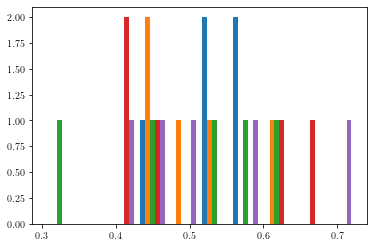

In [74]:
plt.hist(ratio)

In [44]:
print(h)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
